In [1]:
from __future__ import print_function

import numpy as np
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
import scipy.optimize
import scipy.io

from scipy.spatial.distance import cdist
from sklearn import svm
from itertools import izip

plt.style.use('classic')
mpl.rcParams['axes.xmargin'] = 0.0
mpl.rcParams['axes.ymargin'] = 0.0

%matplotlib notebook

In [2]:
data = scipy.io.loadmat ('ex6data1.mat')
X = data['X']
y = data['y'].astype (int)

<IPython.core.display.Javascript object>


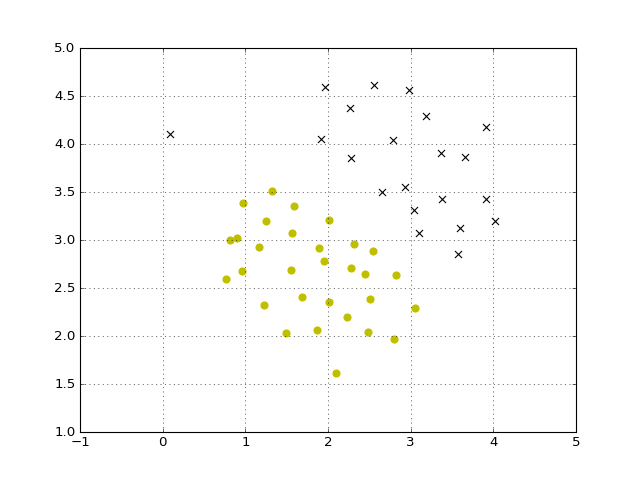

(<matplotlib.figure.Figure at 0x7fb688dee490>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb688deeed0>)

In [3]:
def plotData (X, y):
    idx_pos = (y == 1).T[0]
    idx_neg = ~idx_pos

    fig = plt.figure ()
    ax = fig.add_subplot (111)
    ax.scatter (X[idx_pos, 0], X[idx_pos, 1], color='k', marker='x', s=40)
    ax.scatter (X[idx_neg, 0], X[idx_neg, 1], color='y', marker='o', s=40)
    ax.grid ()

    return (fig, ax)

plotData (X, y)

In [4]:
def svmTrain (X, y, C, kernelFunction, 
              tol=1.e-3, max_iter=5, **kwargs):
    
    m, n = X.shape
    y[y == 0] = -1
    y = y.flatten ()
    
    clf = svm.SVC (kernel=kernelFunction, 
                   C=C, tol=tol, max_iter=max_iter, **kwargs)
    clf.fit (X, y)
    
    return clf

def linearKernel (x1, x2):
    return (x1.dot (x2.T))

In [5]:
C = 1.
model = svmTrain (X, y, C, linearKernel, 1.e-3, 20)

/home/rmaunu/.local/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


<IPython.core.display.Javascript object>


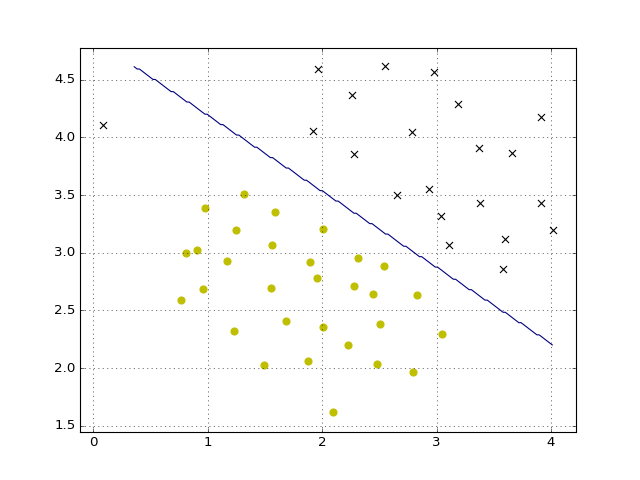

(<matplotlib.figure.Figure at 0x7fb686cdecd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb686cdd590>)

In [6]:
def visualizeBoundary (X, y, model):
    fig, ax = plotData (X, y)
    x1s = np.linspace (np.min (X[:, 0]), np.max (X[:, 0]), 200)
    x2s = np.linspace (np.min (X[:, 1]), np.max (X[:, 1]), 200)
    pred = np.zeros ((len (x1s), len (x2s)))
    for i, x1 in enumerate (x1s):
        for j, x2 in enumerate (x2s):
            pred[i, j] = model.predict ([[x1, x2]])
    x1s_grid, x2s_grid = np.meshgrid (x1s, x2s, indexing='ij')
    ax.contour (x1s_grid, x2s_grid, pred, levels=[0], color='b')
    return (fig, ax)

visualizeBoundary (X, y, model)

In [7]:
def gaussianKernel (x1, x2, sigma):
    pairwise_dists = cdist (x1, x2)
    return (np.exp ((-pairwise_dists**2) / (2 * sigma**2)))

In [8]:
x1 = np.array ([[1., 2., 1.]])
x2 = np.array ([[0., 4., -1.]])
sigma = 2.

sim = gaussianKernel (x1, x2, sigma)
print ('Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = {0:.2f}'.format (sigma))
print ('{0:.6f} (for sigma = 2, this value should be about 0.324652)'.format (sim[0][0]))

Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = 2.00
0.324652 (for sigma = 2, this value should be about 0.324652)


<IPython.core.display.Javascript object>


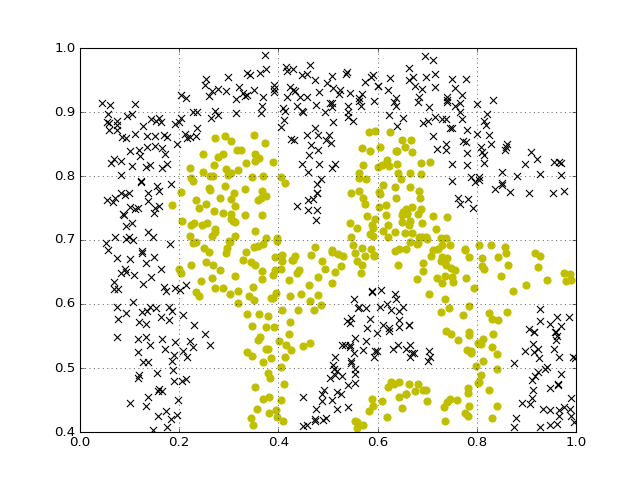

(0.4, 1)

In [9]:
data2 = scipy.io.loadmat ('ex6data2.mat')
X = data2['X']
y = data2['y'].astype ('int')

fig, ax = plotData (X, y)
ax.set_xlim (0, 1)
ax.set_ylim (0.4, 1)

In [10]:
C = 1.
sigma = 0.1

gaussFunc = lambda x1, x2, sigma=sigma: gaussianKernel (x1, x2, sigma)

model = svmTrain (X, y, C, gaussFunc,  tol=1.e-3, max_iter=100)

/home/rmaunu/.local/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


<IPython.core.display.Javascript object>


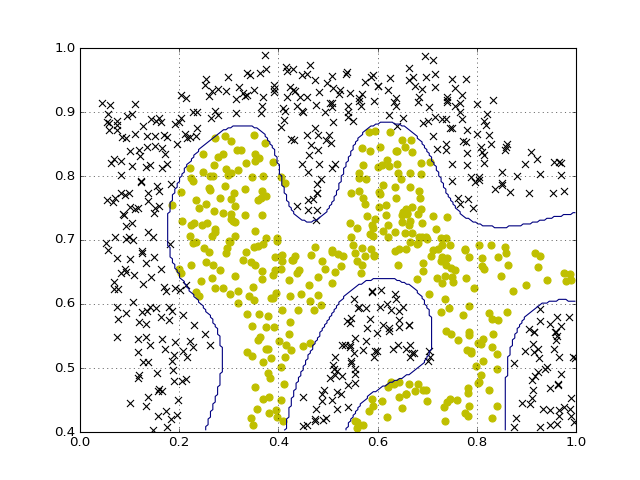

(0.4, 1)

In [11]:
fig, ax = visualizeBoundary (X, y, model)
ax.set_xlim (0, 1)
ax.set_ylim (0.4, 1)

In [33]:
data3 = scipy.io.loadmat ('ex6data3.mat')
X = data3['X']
X_val = data3['Xval']
y = data3['y'].astype ('int')
y_val = data3['yval'].astype ('int')
y_val[y_val == 0] = -1

In [48]:
def optimizeMetaParamsSVM (X, y, X_val, y_val):
    C_search = np.logspace (-2, 2, 9)[:-1]
    sigma_search = np.logspace (-2, 2, 9)[:-1]
    
    error_vals = np.zeros ((len (C_search), len (sigma_search)))
    
    for i, C in enumerate (C_search):
        for j, sigma in enumerate (sigma_search):
            print ('Testing C={0:.3f}, sigma={1:.3f}'.format (
                C, sigma))
            kernel = lambda x1, x2, sigma=sigma: gaussianKernel (
                x1, x2, sigma)
            model = svmTrain (X, y, C, kernel, 
                              tol=1.e-3, max_iter=100)
            pred = model.predict (X_val)
            error_vals[i, j] = np.mean (np.not_equal(pred, y_val.flatten ()).astype ('float'))
            print ('Cross Validation Error Rate = {0:.2f}%'.format (
                100 * error_vals[i, j]))
            
    idx = np.unravel_index (error_vals.argmin (), error_vals.shape)
    return (C_search[idx[0]], sigma_search[idx[1]])
            

In [49]:
C, sigma = optimizeMetaParamsSVM (X, y, X_val, y_val)
kernel = lambda x1, x2, sigma=sigma: gaussianKernel (x1, x2, sigma)
model = svmTrain (X, y, C, kernel,
                  tol=1.e-3, max_iter=100)

Testing C=0.010, sigma=0.010
Cross Validation Error Rate = 39.00%
Testing C=0.010, sigma=0.032
Cross Validation Error Rate = 19.00%
Testing C=0.010, sigma=0.100
Cross Validation Error Rate = 6.50%
Testing C=0.010, sigma=0.316
Cross Validation Error Rate = 14.50%
Testing C=0.010, sigma=1.000
Cross Validation Error Rate = 18.00%
Testing C=0.010, sigma=3.162
Cross Validation Error Rate = 22.00%
Testing C=0.010, sigma=10.000
Cross Validation Error Rate = 22.00%
Testing C=0.010, sigma=31.623
Cross Validation Error Rate = 22.00%
Testing C=0.032, sigma=0.010
Cross Validation Error Rate = 39.00%
Testing C=0.032, sigma=0.032
Cross Validation Error Rate = 8.00%
Testing C=0.032, sigma=0.100
Cross Validation Error Rate = 5.00%
Testing C=0.032, sigma=0.316
Cross Validation Error Rate = 14.50%
Testing C=0.032, sigma=1.000
Cross Validation Error Rate = 18.00%
Testing C=0.032, sigma=3.162
Cross Validation Error Rate = 22.00%
Testing C=0.032, sigma=10.000
Cross Validation Error Rate = 22.00%
Testing C=

<IPython.core.display.Javascript object>


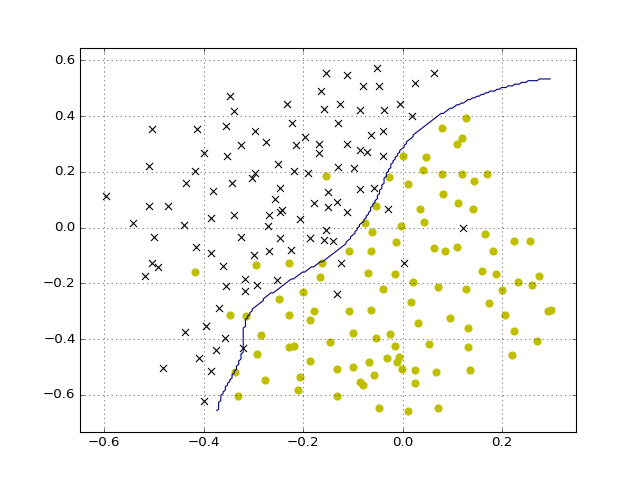

(<matplotlib.figure.Figure at 0x7fb6850fff90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb68509cf10>)

In [50]:
visualizeBoundary (X, y, model)

## Now, on to the spam filter

In [317]:
import re
from stemming.porter2 import stem

def getVocabList ():
    vocabListRaw = np.genfromtxt ('vocab_py.txt', delimiter='\t', dtype='str')
    vocabList = vocabListRaw[:, 1].tolist ()
    return (vocabList)

def processEmail (email_contents):
    vocabList = getVocabList ()
    word_indices = []
    
    email_contents = email_contents.lower () # Lowercase everything
    email_contents = re.sub (r"\n", r" ", 
                             email_contents) # Strip newline characters
    email_contents = re.sub (r"\r", r" ", 
                             email_contents) # Strip newline characters
    email_contents = re.sub (r'<[^<>]+>', r' ', 
                             email_contents) # Strip HTML
    email_contents = re.sub (r'[0-9]+', r'number', 
                             email_contents) # Strip numbers
    email_contents = re.sub (r'(http|https)://[^\s]*', r'httpaddr', 
                             email_contents) # Strip web addresses
    email_contents = re.sub (r'[^\s]+@[^\s]+', r'emailaddr', 
                             email_contents) # Strip email addresses
    email_contents = re.sub (r'[$]+', r'dollar', 
                             email_contents) # Strip dollar signs
    
    email_contents_list = re.split (r'[ @$/#.-:&*+=\[\]?!(){},\'">_<;%]',
                                    email_contents)
    
    print ('')
    print ('==== Processed Email ====')
    print ('')
    
    l = 0
    for word in email_contents_list:
        if word == '':
            continue
        word_stem = stem (word)
        
        l += len (word_stem) + 1
        if (l > 60):
            print ('')
            l = 0
        print (word_stem, end=' ')
        try:
            idx = vocabList.index (word_stem)
        except:
            continue
        word_indices.append (idx)
        
    print ('')
    print ('')
    
    return (word_indices)

def emailFeatures (word_indices):
    n = 1899
    
    x = np.zeros ((n, 1), dtype='int')
    x[np.array (word_indices)] = 1
    return (x)

In [318]:
print ('Processing sample email (emailSample1.txt)')
f = open ('emailSample1.txt')
email_contents = f.read ()
word_indices = processEmail (email_contents)
print ('Word indices:', word_indices)

Processing sample email (emailSample1.txt)

==== Processed Email ====

anyon know how much it cost to host a web portal well it 
depend on how mani visitor you re expect this can be anywher from 
less than number buck a month to a coupl of dollarnumb you 
should checkout httpaddr or perhap amazon ecnumb if your run 
someth big to unsubscrib yourself from this mail list send an 
email to emailaddr 

Word indices: [85, 915, 793, 1076, 882, 369, 1698, 789, 1821, 1830, 882, 430, 1170, 793, 1001, 1892, 1363, 591, 1675, 237, 161, 88, 687, 944, 1662, 1119, 1061, 1698, 374, 1161, 478, 1892, 1509, 798, 1181, 1236, 809, 1894, 1439, 1546, 180, 1698, 1757, 1895, 687, 1675, 991, 960, 1476, 70, 529, 1698, 530]


In [206]:
print ('Extracting features from sample email (emailSample1.txt)')

f = open ('emailSample1.txt')
email_contents = f.read ()
word_indices = processEmail (email_contents)
features = emailFeatures (word_indices)

print ('Length of feature vector: {0:d}'.format (len (features)))
print ('Number of non-zero entries: {0:d}'.format (features.sum ()))

Extracting features from sample email (emailSample1.txt)
Length of feature vector: 1899
Number of non-zero entries: 45


In [247]:
data = scipy.io.loadmat ('spamTrain.mat')
X = data['X']
y = data['y'].astype ('int')
y[y == 0] = -1
data = scipy.io.loadmat ('spamTest.mat')
X_test = data['Xtest']
y_test = data['ytest'].astype ('int')
y_test[y_test == 0] = -1

In [261]:
C = 0.1
model = svmTrain (X, y, C, 'linear', 
                  tol=1.e-3, max_iter=1000)

In [262]:
p = model.predict (X)
print ('Training Accuracy: {0:.2f}%'.format (
        np.mean (p == y.flatten ()) * 100))

Training Accuracy: 99.83%


In [263]:
p = model.predict (X_test)
print ('Testing Accuracy: {0:.2f}%'.format (
        np.mean (p == y_test.flatten ()) * 100))

Testing Accuracy: 98.90%


In [287]:
idx_sort = model.coef_.argsort ()[0][::-1]
weights_sort = np.sort (model.coef_)[0][::-1]
vocab_list = getVocabList ()

print ('Top predictors of spam:')
for i in range (15):
    print (' {0} ({1:.6f})'.format (vocabList[idx_sort[i]], 
                                     weights_sort[i]))

Top predictors of spam:
 our (0.499093)
 click (0.465752)
 remov (0.423826)
 guarante (0.380659)
 visit (0.365588)
 basenumb (0.344326)
 dollar (0.323957)
 will (0.268891)
 price (0.267154)
 pleas (0.262308)
 most (0.256607)
 lo (0.256074)
 nbsp (0.252209)
 ga (0.247107)
 hour (0.244792)


In [319]:
filename = 'spamSample1.txt'
f = open (filename)
email_contents = f.read ()
word_indices = processEmail (email_contents)
features = emailFeatures (word_indices)
p = model.predict (features.T)

print ('Processed {0}\n\nSpam Classification: {1:d}'.format (
        filename, p[0]))
print ('(1 indicates spam, -1 indicates not spam)')


==== Processed Email ====

do you want to make dollarnumb or more per week if you are 
a motiv and qualifi individu - i will person demonstr to you 
a system that will make you dollarnumb number per week or 
more this is not mlm call our number hour pre-record number to 
get the detail number-number-numb i need peopl who want to make 
serious money make the call and get the fact invest number minut in 
yourself now number-number-numb look forward to your call and i will 
introduc you to peopl like yourself who are current make dollarnumb 
number plus per week number-number-numb 
numberljgvnumber-numberleannumberlrmsnumber-numberwxhonumberqiytnumber-numberrjuvnumberhqcfnumber-numbereidbnumberdmtvlnumb 

Processed spamSample1.txt

Spam Classification: 1
(1 indicates spam, -1 indicates not spam)
